In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  


In [3]:
%pwd


'/Users/mayanknautiyal/Desktop/Codes/CVAEI/notebooks'

In [4]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.examples.villar import Villar
from cvaei.models.conv_cvae import CNN_CVAE
import multiprocessing as mp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [5]:
villar = Villar()
mp.set_start_method('spawn')
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = villar.prepare_data(10, scale = True)
observed_data = villar.observed_data()
#villar.check_normalizer()

Generating data...
8


Training Theta Shape: torch.Size([10, 15])
Training Data Shape: torch.Size([10, 3, 200])
Generating data...
8
Validation Theta Shape: torch.Size([4, 15])
Validation Data Shape: torch.Size([4, 3, 200])
torch.Size([1, 3, 200])


In [6]:
train_data_norm[3]

tensor([[0.0000e+00, 2.2059e-02, 1.2010e-01, 2.7696e-01, 4.6373e-01, 6.6716e-01,
         8.0637e-01, 3.7059e-01, 2.1373e-01, 1.4363e-01, 1.4804e-01, 1.3725e-01,
         1.6471e-01, 1.0147e-01, 1.1127e-01, 1.2892e-01, 1.2206e-01, 1.0392e-01,
         1.2108e-01, 1.1912e-01, 1.0686e-01, 2.1471e-01, 2.4755e-01, 3.4951e-01,
         4.9314e-01, 6.2157e-01, 7.7549e-01, 9.5245e-01, 5.2255e-01, 3.0441e-01,
         2.2843e-01, 1.5784e-01, 1.5343e-01, 1.1618e-01, 1.0588e-01, 1.0245e-01,
         1.3039e-01, 9.5588e-02, 9.6078e-02, 1.1225e-01, 1.1029e-01, 9.9020e-02,
         1.2255e-01, 8.5294e-02, 1.1471e-01, 1.6863e-01, 2.3333e-01, 3.9216e-01,
         5.6765e-01, 7.2549e-01, 7.8529e-01, 3.8186e-01, 2.3627e-01, 1.4020e-01,
         1.3627e-01, 1.1078e-01, 1.0882e-01, 1.2500e-01, 1.1716e-01, 1.2892e-01,
         1.2157e-01, 1.0980e-01, 1.0098e-01, 1.4118e-01, 1.1667e-01, 1.1078e-01,
         9.7059e-02, 9.8039e-02, 1.0588e-01, 1.8529e-01, 2.5833e-01, 4.0049e-01,
         5.7647e-01, 7.7794e

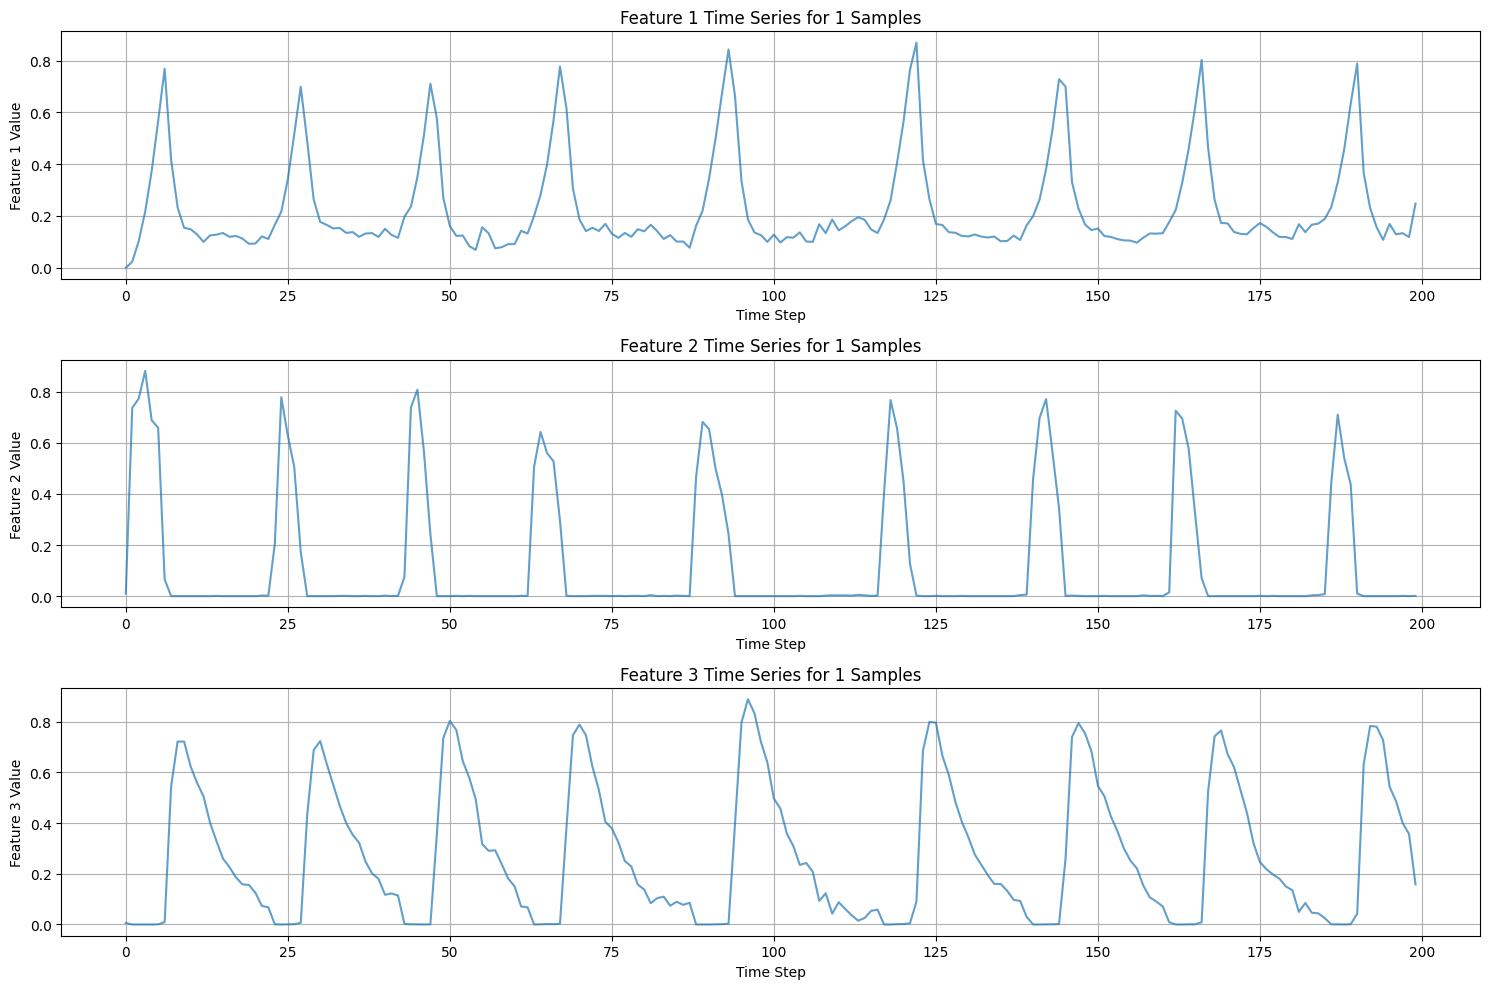

In [7]:
villar.plot_observation(observed_data)

# Initialise the Model

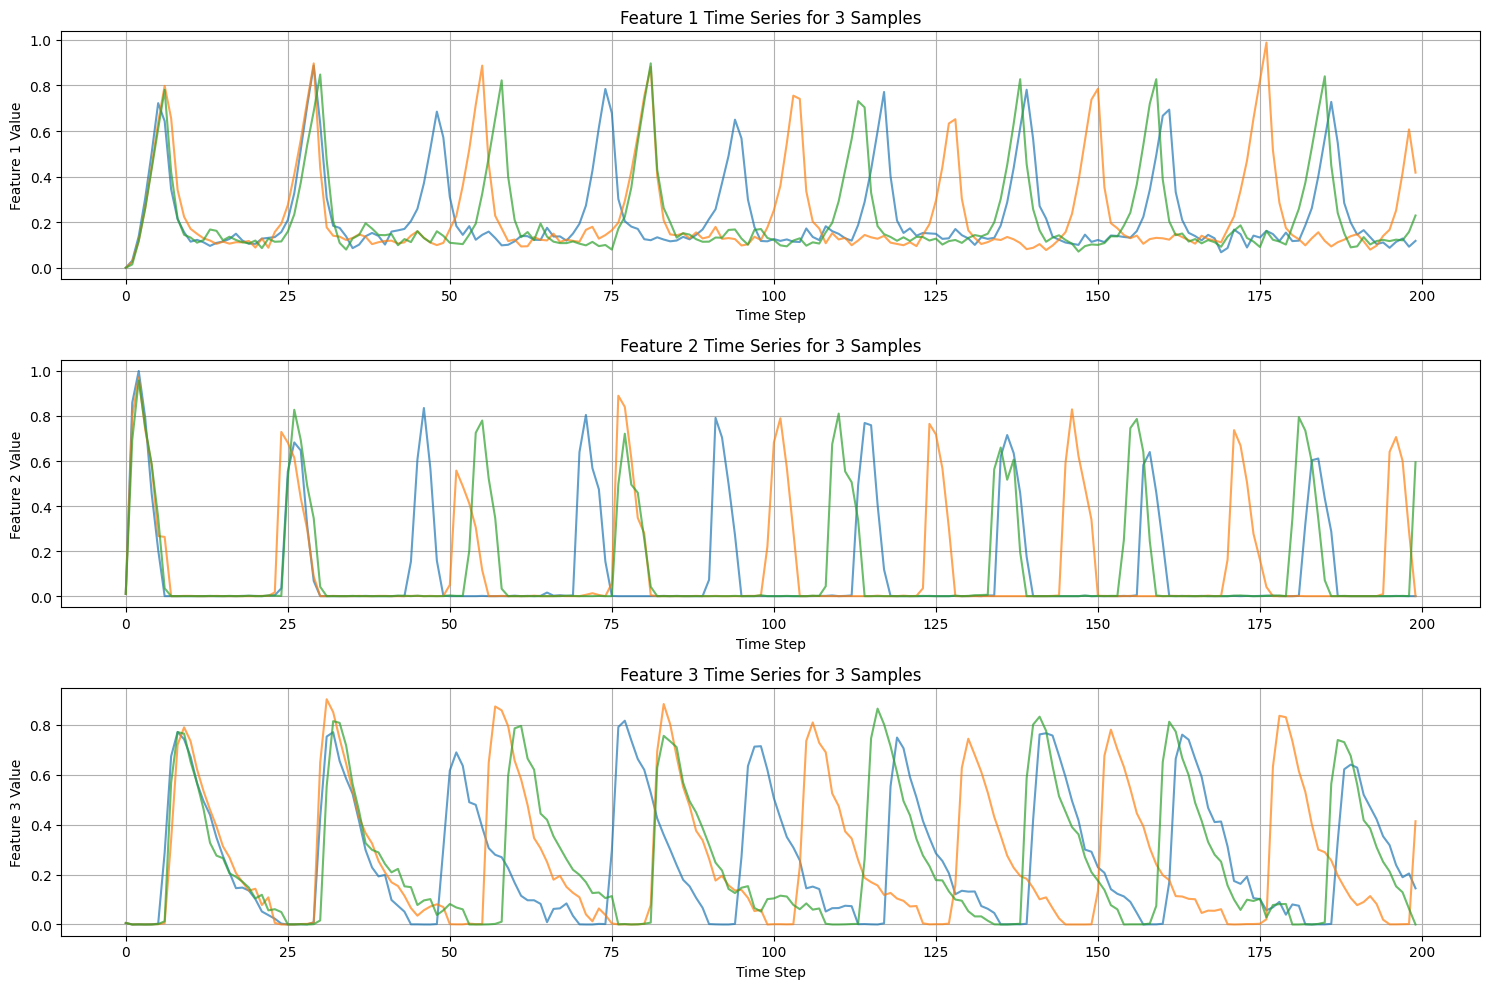

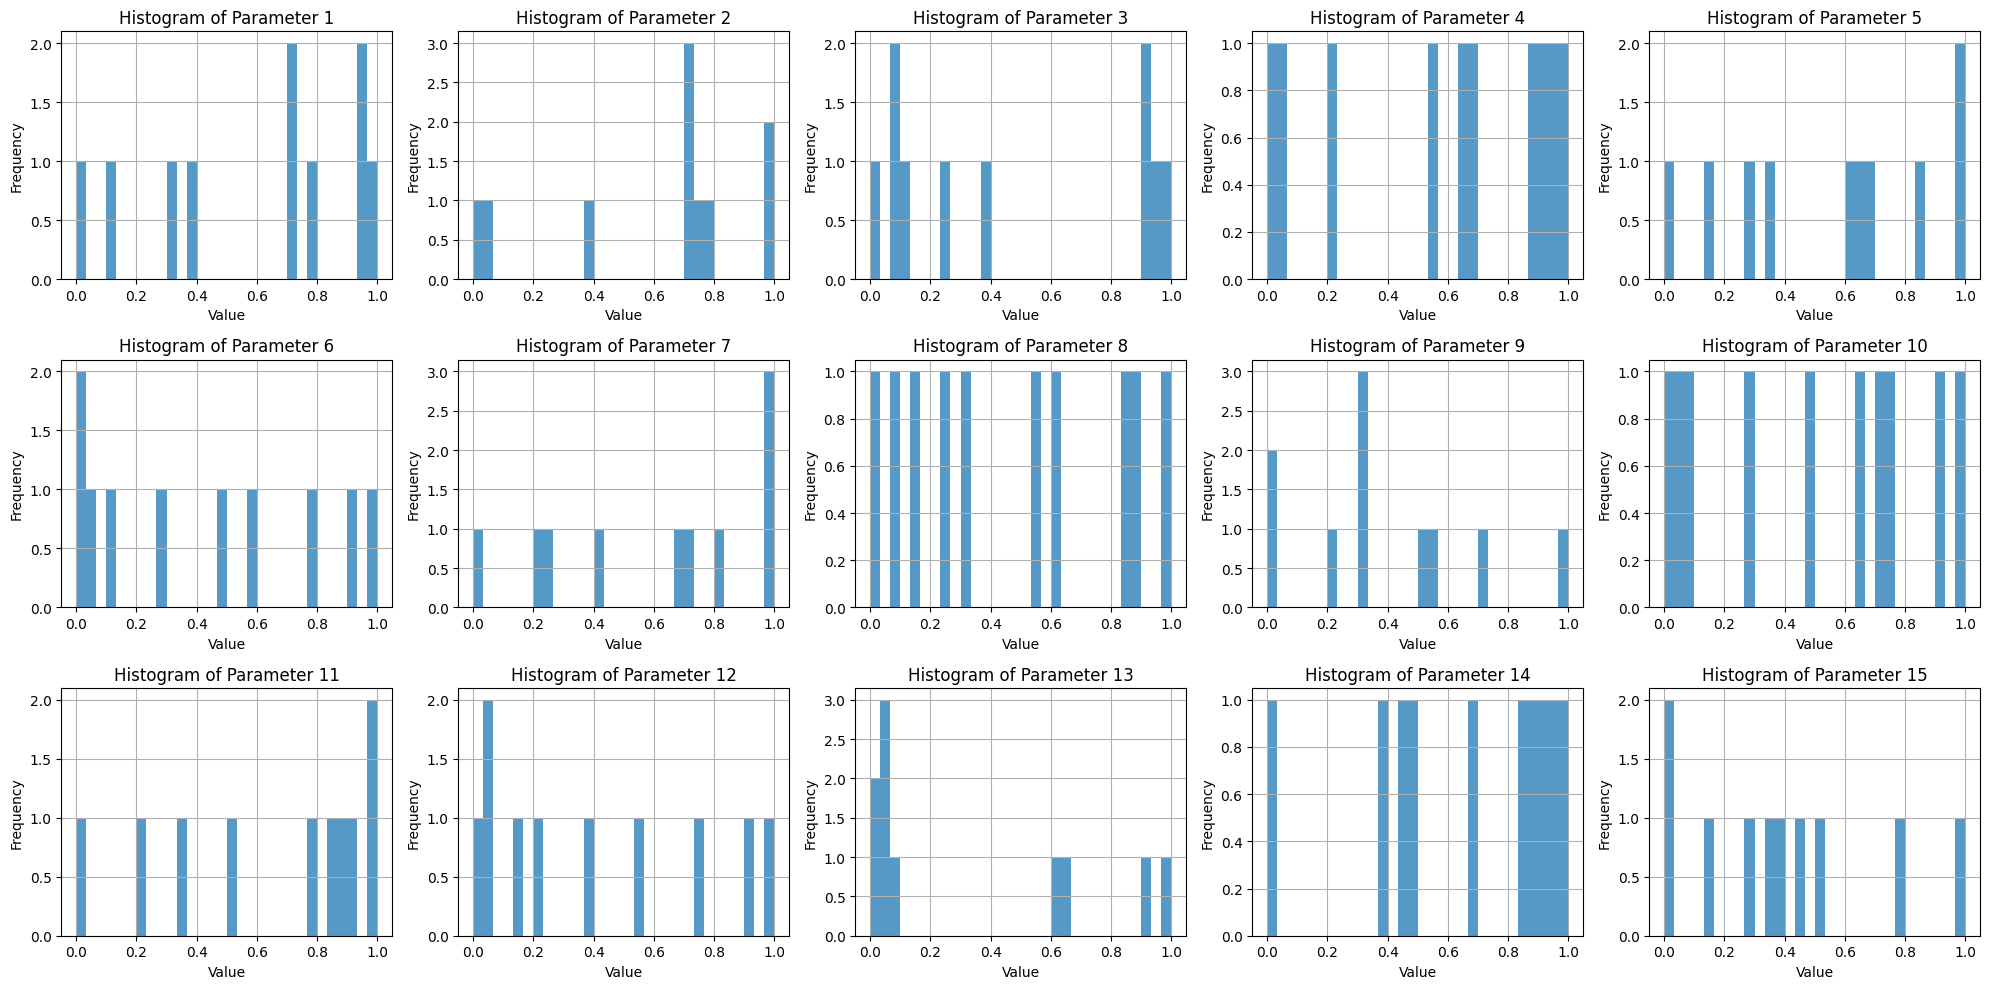

In [8]:
villar.plot_observation(train_data_norm, num_samples =3)
villar.plot_prior(train_theta_norm)

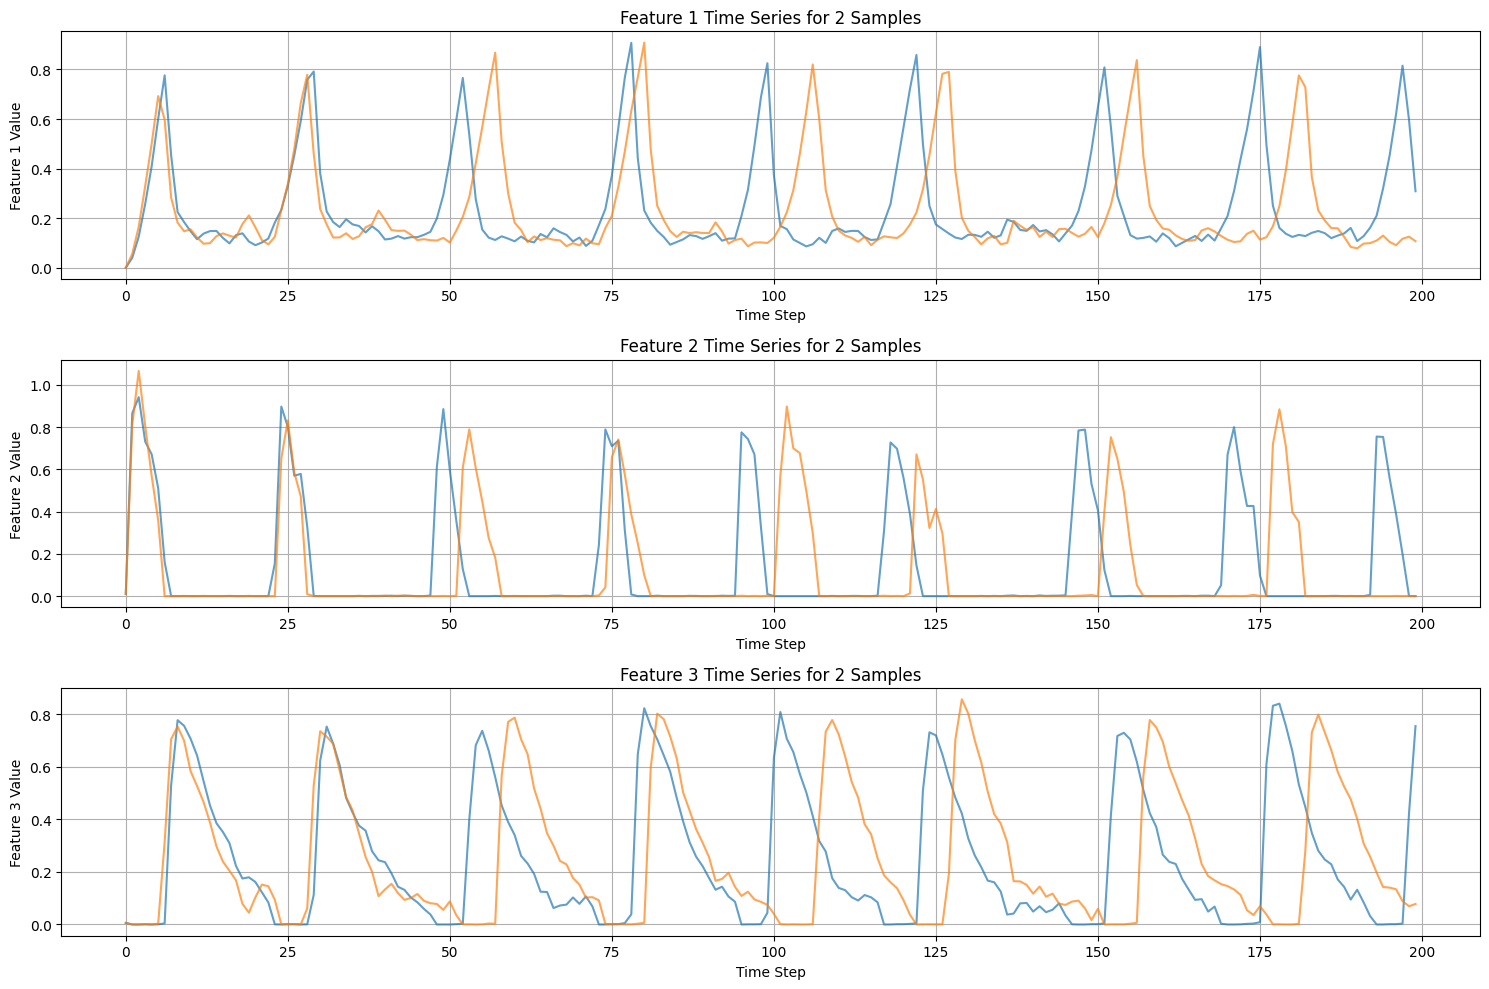

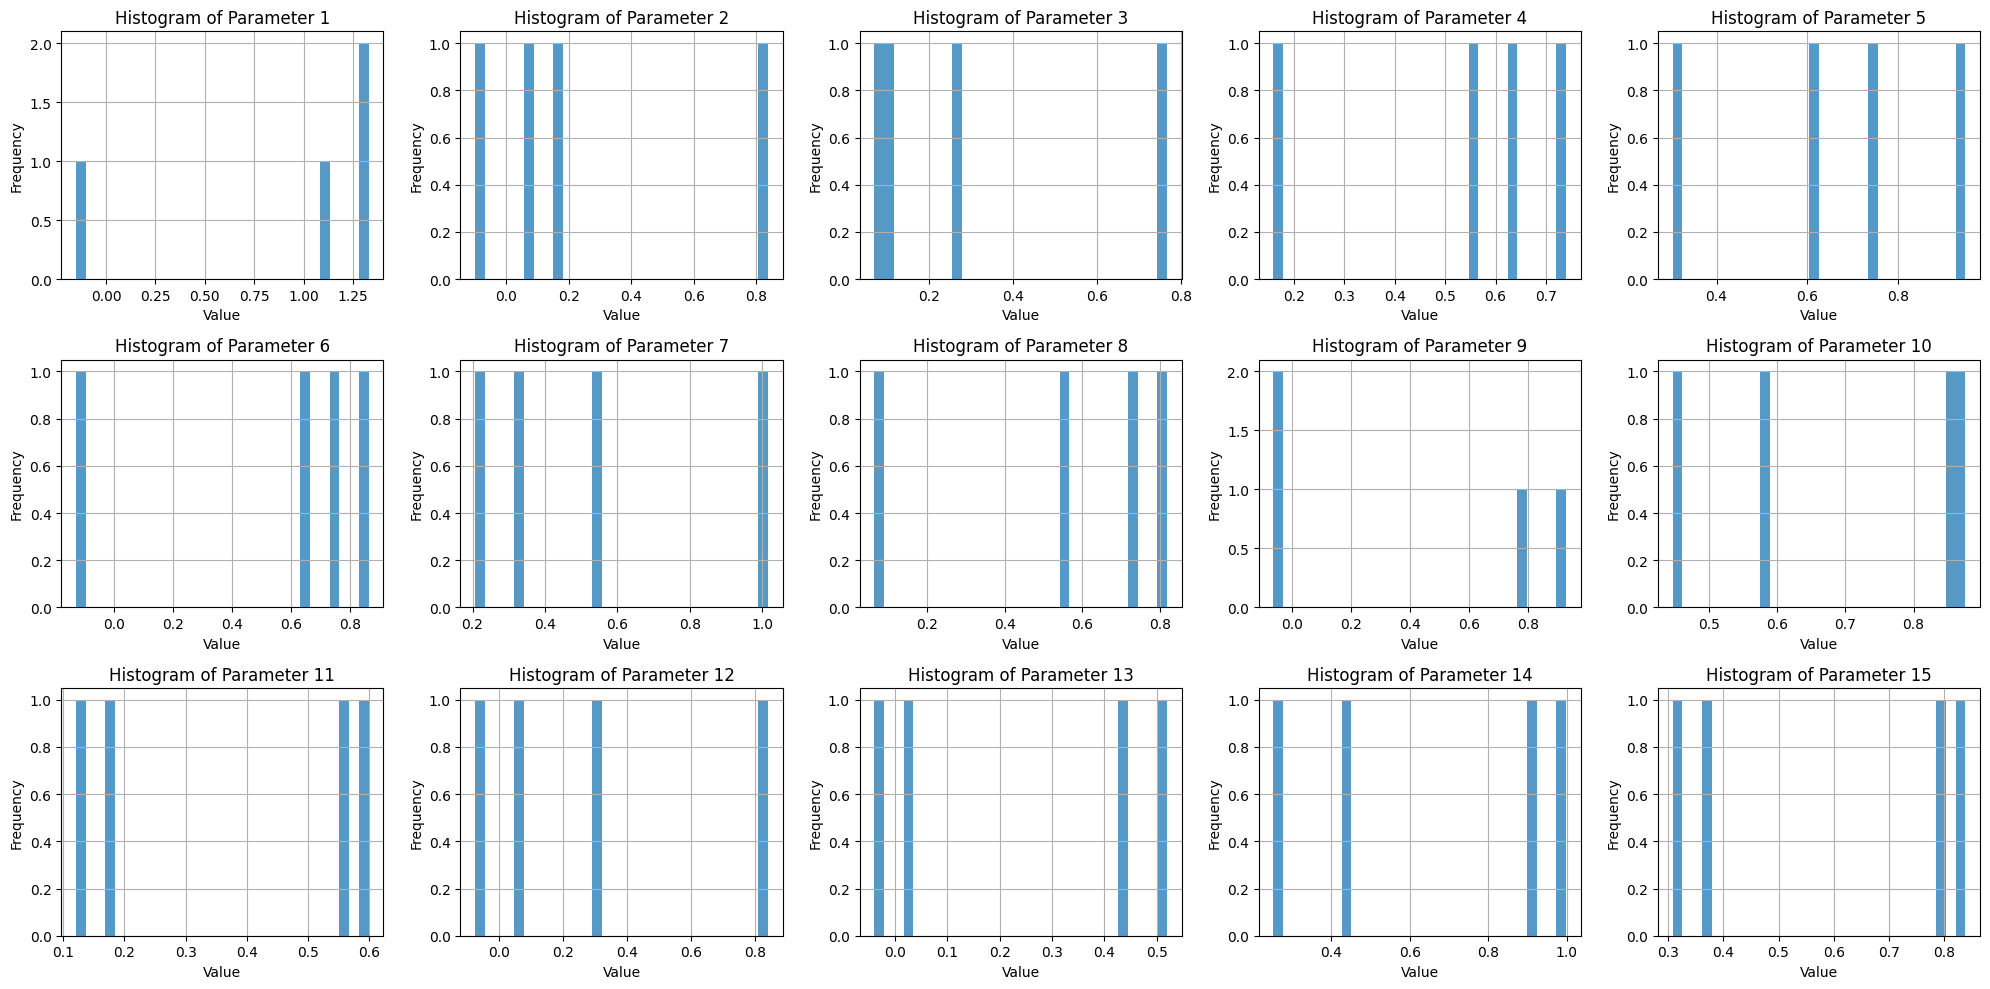

In [9]:
villar.plot_observation(val_data_norm, num_samples =2)
villar.plot_prior(val_theta_norm)

# Define the CVAE Network

In [10]:
# Instantiate the CNN_CVAE model
input_dim = 15  # Example input dimension
latent_dim = 200  # Example latent space dimension
conditional_dim = 3  # Based on Nx3x200 conditional input
encoder_hidden_dims = [200]  # Example hidden dimensions for the encoder
sequence_length = 200  # Length of sequences in the conditional input
conv_output_channels = [64, 32]  # Channels in each Conv1D layer for the decoder
kernel_sizes = [3, 3]  # Kernel sizes for the Conv1D layers in the decoder
output_channels = 3  # Matching the original conditional input's channels



network = CNN_CVAE(
    input_dim=input_dim,
    latent_dim=latent_dim,
    conditional_dim=conditional_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=[],  # Assuming this is not used in the provided structure
    sequence_length=sequence_length,
    conv_output_channels=conv_output_channels,
    kernel_sizes=kernel_sizes,
    activation_fn= nn.LeakyReLU(0.1),
    w_recon=1.0,
    w_misfit=0.1,
    kld=1.0
)

optimizer = optim.AdamW(network.parameters(), lr=1e-5)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

print(network)

CNN_CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=15, out_features=200, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=200, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=200, out_features=200, bias=True)
  )
  (decoder): CNN_Decoder(
    (fc_expand): Linear(in_features=200, out_features=200, bias=True)
    (conv_layers): ModuleList(
      (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (output_layer_1): Linear(in_features=6400, out_features=15, bias=True)
    (output_layer_2): Conv1d(32, 3, kernel_size=(1,), stride=(1,))
  )
)


In [11]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20,
                    num_cycles = 1,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    
                    patience=100)

Using CPU for training.
Epoch 1/20: Beta: 0.0, total_loss: 12.0737, recon_loss: 6.0297, misfit_loss: 6.0440, kl_div: 0.0000
Epoch 1/20 Validation: total_loss: 11.7204, recon_loss: 5.8093, misfit_loss: 5.9110, kl_div: 0.0000

Epoch 1: Validation loss improved to 2.93008757
Epoch 2/20: Beta: 0.1, total_loss: 12.3431, recon_loss: 5.9301, misfit_loss: 6.0037, kl_div: 0.4093
Epoch 2/20 Validation: total_loss: 12.0571, recon_loss: 5.7221, misfit_loss: 5.9133, kl_div: 0.4218

Epoch 2: No improvement in validation loss for 1 epochs.
Epoch 3/20: Beta: 0.2, total_loss: 12.7540, recon_loss: 5.9116, misfit_loss: 6.0254, kl_div: 0.8170
Epoch 3/20 Validation: total_loss: 12.3138, recon_loss: 5.5835, misfit_loss: 5.8887, kl_div: 0.8415

Epoch 3: No improvement in validation loss for 2 epochs.
Epoch 4/20: Beta: 0.3, total_loss: 13.0857, recon_loss: 5.8451, misfit_loss: 6.0182, kl_div: 1.2223
Epoch 4/20 Validation: total_loss: 12.7355, recon_loss: 5.5798, misfit_loss: 5.8967, kl_div: 1.2590

Epoch 4: N

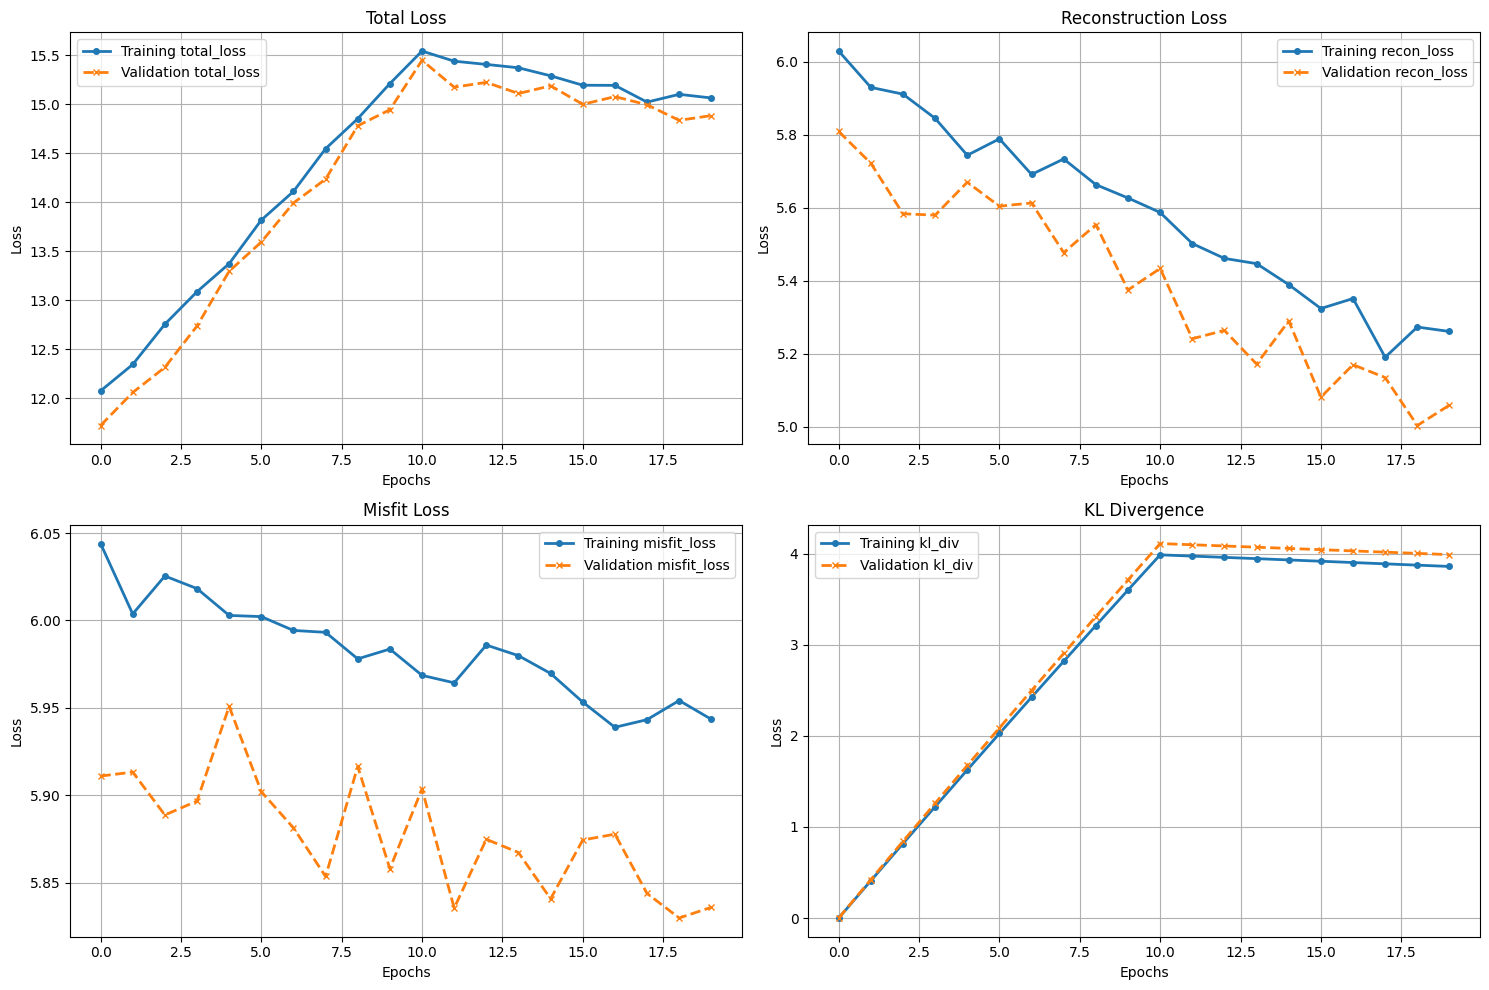

In [12]:
network.plot_loss()

# Inference

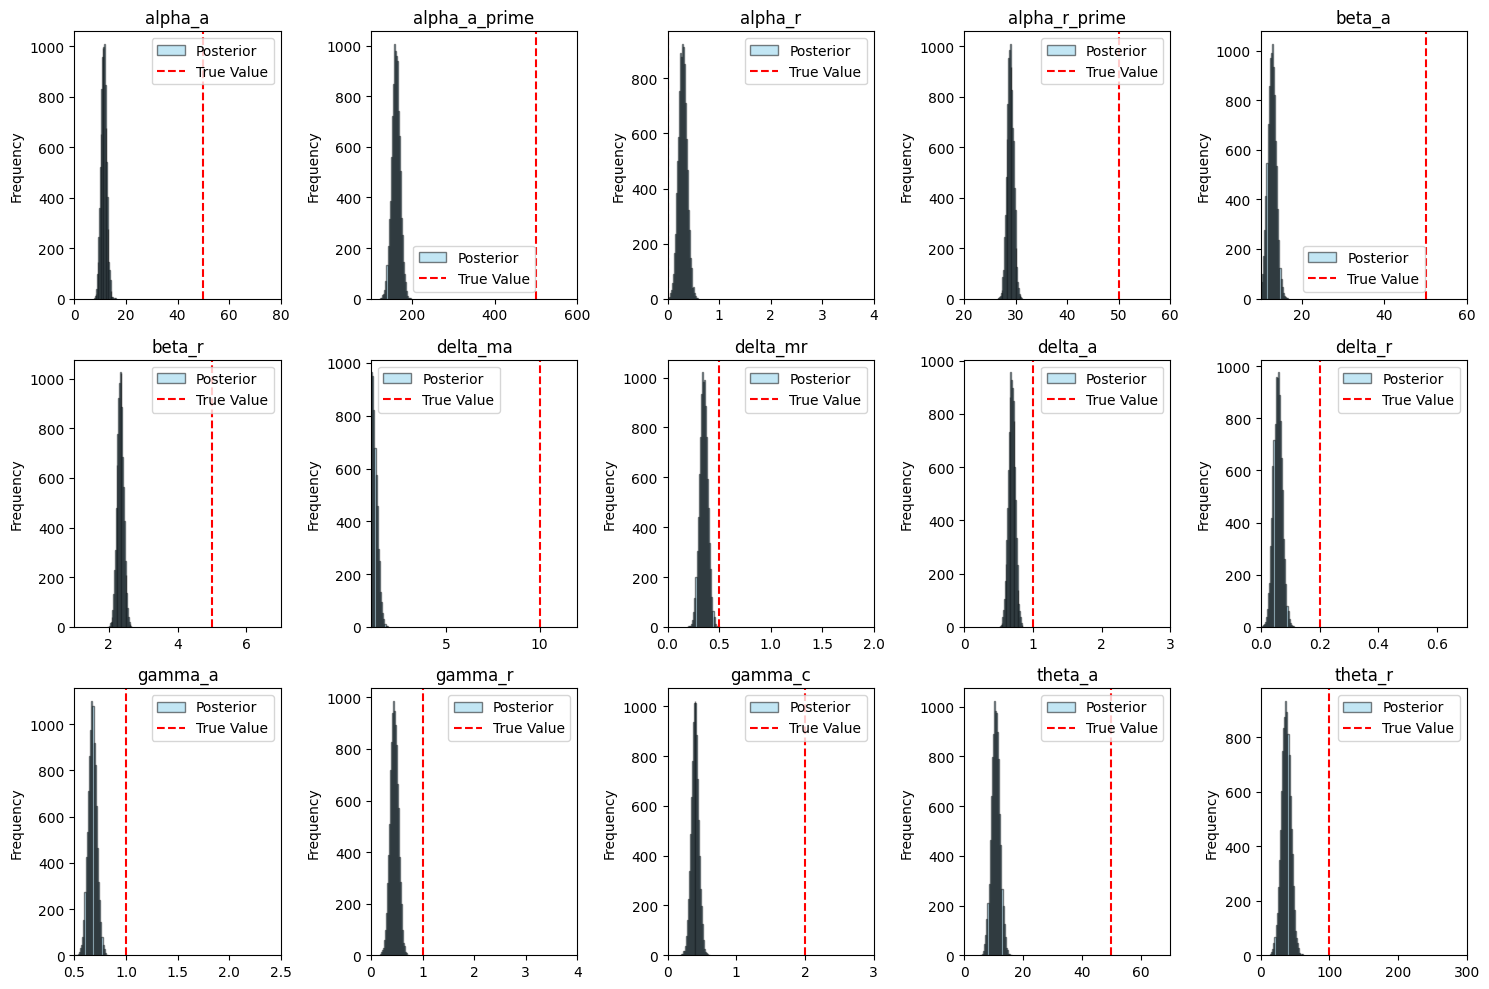

In [13]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)
villar.posterior_hist(post)